In [1]:
%load_ext autoreload
%autoreload 2
import os, sys, glob
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import jax
from jax import lax, nn, random
import jax.numpy as jnp
import haiku as hk
import optax
%matplotlib inline

/Users/aptx4869/opt/anaconda3/envs/grl/lib/python3.8/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [2]:
def plot_data(data, x, y, outdir, tag, title, timing=None, smooth=1):
    if smooth > 1:
        """
        smooth data with moving window average.
        that is,
            smoothed_y[t] = average(y[t-k], y[t-k+1], ..., y[t+k-1], y[t+k])
        where the "smooth" param is width of that window (2k+1)
        """
        y = np.ones(smooth)
        for datum in data:
            x = np.asarray(datum[y])
            z = np.ones(len(x))
            smoothed_x = np.convolve(x,y,'same') / np.convolve(z,y,'same')
            datum[y] = smoothed_x
            
    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)
        if timing:
            data = data[data.timing == timing].drop('timing', axis=1)

    if not os.path.isdir(outdir):
        os.mkdir(outdir)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    sns.set(style="whitegrid", font_scale=1.5)
    sns.set_palette('Set2') # or husl
    if 'timing' in data.columns:
        sns.lineplot(x=x, y=y, ax=ax, data=data, hue=tag, style='timing')
    else:
        sns.lineplot(x=x, y=y, ax=ax, data=data, hue=tag)
    ax.grid(True, alpha=0.8, linestyle=':')
    ax.legend(loc='best').set_draggable(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if timing:
        title = f'{title}-{timing}'
    outpath = f'{outdir}/{title}.png'
    ax.set_title(title)
    fig.savefig(outpath)
    fig.show()
    print(f'Plot Path: {outpath}')

def get_datasets(files, tag, condition=None):
    unit = 0
    datasets = []
    for f in files:
        assert f.endswith('log.txt')
        data = pd.read_csv(f, sep='\t')

        data.insert(len(data.columns), tag, condition)

        datasets.append(data)
        unit +=1

    return datasets

In [16]:
def payoff(*, p1=None, p2=None):
    if p1 is None:
        p = np.matmul(ps1, p2)
    else:
        p = np.matmul(p1.T, ps2)

    return p

def get_random_pi():
    p1 = np.random.uniform(0, 1, A)
    p1 = p1 / np.sum(p1)
    return p1

def get_prob(x):
    return x / np.sum(x)

def compute_obj(q, x, p):
    return np.sum(eta * x * q - x * (np.log(x) - np.log(p)))


for _ in range(10000):
    A = np.random.randint(2, 10)
    V = 10

    ps1 = np.random.uniform(0, V, (A, A))
    ps2 = np.random.uniform(0, V, (A, A))
    eta = 1 / V
    p1 = get_random_pi()
    p2 = get_random_pi()
    pi1 = get_random_pi()
    pi2 = get_random_pi()

    for i in range(100000):
        q1 = payoff(p2=pi2)
        q2 = payoff(p1=pi1)
        new_pi1 = get_prob(p1 * np.exp(eta * q1))
        new_pi2 = get_prob(p2 * np.exp(eta * q2))
        if np.all(np.abs(new_pi1 - pi1) < 1e-7) and np.all(np.abs(new_pi2 - pi2) < 1e-7):
            break
        pi1 = new_pi1
        pi2 = new_pi2
#     print(i)
    q1 = payoff(p2=pi2)
    q2 = payoff(p1=pi1)
    tp1 = get_prob(p1 * np.exp(eta * q1))
    tp2 = get_prob(p2 * np.exp(eta * q2))

    np.testing.assert_allclose(pi1, tp1, 1e-3)
    np.testing.assert_allclose(pi2, tp2, 1e-3)

    pv1 = compute_obj(q1, pi1, p1)
    pv2 = compute_obj(q2, pi2, p2)

    pi1_pt = get_prob(pi1+np.random.uniform(0, .1, pi1.shape))
    pi2_pt = get_prob(pi2+np.random.uniform(0, .1, pi2.shape))

    pv1_pt = compute_obj(q1, pi1_pt, p1)
    pv2_pt = compute_obj(q2, pi2_pt, p2)

    assert pv1_pt <= pv1, (pv1_pt, pv1)
    assert pv2_pt <= pv2, (pv2_pt, pv2)

In [19]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd

ind = tfd.Independent(
      distribution=tfd.MultivariateNormalDiag(
          loc=[[[-1., 1], [1, -1]]],
          scale_diag=tf.tile([[[1.], [0.5]]], [1, 1, 2])),
      reinterpreted_batch_ndims=1)

print(ind.batch_shape)
print(ind.event_shape)

(1,)
(2, 2)


In [23]:
x = {'a': 10}
{**x, 'a': 3}

{'a': 3}

In [297]:
from jax import lax, random, nn

b = 1
d = 2
rng = random.PRNGKey(0)
rngs = random.split(rng)
x = random.normal(rngs[0], (b, d))
y = random.normal(rngs[1], (b, d))

def f(y, x):
    xprob = nn.softmax(x)
    xlogprob = nn.log_softmax(x)
    ylogprob = nn.log_softmax(y)
    kl = jnp.sum(xprob * (xlogprob - ylogprob), -1)
    return kl.mean()

std_grads = jax.grad(f)(x, y)

xprob = nn.softmax(x)
yprob = nn.softmax(y)
manual_grads = xprob - yprob
print(std_grads, manual_grads)
chex.assert_trees_all_close(std_grads, manual_grads)

[[-0.01285148  0.01285153]] [[-0.01285148  0.01285154]]


In [13]:
4**.4

1.7411011265922482

In [12]:
0.24**.4

0.5650469000989533

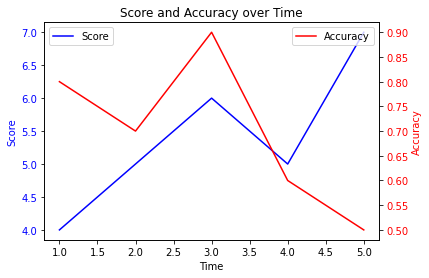

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some example data
time = [1, 2, 3, 4, 5]
score = [4, 5, 6, 5, 7]
accuracy = [0.8, 0.7, 0.9, 0.6, 0.5]

# Create a new figure and axis
fig, ax1 = plt.subplots()

# Plot the score data against time on the first y-axis
sns.lineplot(x=time, y=score, ax=ax1, label='Score', color='blue')

# Set the label and color of the first y-axis
ax1.set_ylabel('Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis and plot the accuracy data against time on it
ax2 = ax1.twinx()
sns.lineplot(x=time, y=accuracy, ax=ax2, label='Accuracy', color='red')

# Set the label and color of the second y-axis
ax2.set_ylabel('Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the x-axis label and plot title
ax1.set_xlabel('Time')
plt.title('Score and Accuracy over Time')

# Display the plot
plt.show()


In [3]:
x = 'abc123'

x[[x.isdigit()]]

'a'